In [6]:
import pandas as pd
import requests
import time
import io
from collections import Counter, defaultdict
from localcider.sequenceParameters import SequenceParameters
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from typing import List, Tuple, Dict

## Phase 2: GDA retrieval (Alzheimer vs Parkinson)

In [4]:
alzheimer_file = "GDA_Alzheimer.tsv"
parkinson_file = "GDA_Parkinson.tsv"

cols_to_keep = [
    "gene_symbol", "gene_ensembl", "genep_str_ids",
    "disease_name", "score", "dsi", "gene_type", "geneDescription"
]

alzheimer = pd.read_csv(alzheimer_file, sep="\t", usecols=cols_to_keep)
parkinson = pd.read_csv(parkinson_file, sep="\t", usecols=cols_to_keep)

In [6]:
# HELPER FUNCTIONS
# === Function to fetch UniProt sequence ===
def fetch_uniprot_sequence(uniprot_id):
    """Fetch canonical FASTA sequence and length from UniProt API."""
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta"
    r = requests.get(url)
    if r.status_code == 200:
        fasta = r.text
        seq = "".join(line.strip() for line in fasta.split("\n") if not line.startswith(">"))
        return seq, len(seq)
    return None, None

# === Add UniProt sequences ===
def add_sequences(df):
    seqs, lengths = [], []
    for uid in df["genep_str_ids"]:
        if pd.isna(uid):  # missing UniProt ID
            seqs.append(None)
            lengths.append(None)
        else:
            seq, l = fetch_uniprot_sequence(uid)
            seqs.append(seq)
            lengths.append(l)
    df["sequence"] = seqs
    df["seq_length"] = lengths
    return df

In [8]:
alzheimer = add_sequences(alzheimer)
parkinson = add_sequences(parkinson)

# === Save clean & full lists ===
alzheimer.to_csv("Alzheimer_Full_Genes.tsv", sep="\t", index=False)
parkinson.to_csv("Parkinson_Full_Genes.tsv", sep="\t", index=False)

print("Phase 2 completed: Clean & filtered gene lists saved with UniProt sequences.")

Phase 2 completed: Clean & filtered gene lists saved with UniProt sequences.


In [11]:
alzheimer.head(5)

,gene_symbol,score,gene_ensembl,disease_name,geneDescription,gene_type,genep_str_ids,dsi,sequence,seq_length
0,APP,1.0,ENSG00000142192,Alzheimer's Disease,amyloid beta precursor protein,protein-coding,P05067,0.40,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,770.0
1,PSEN1,1.0,ENSG00000080815,Alzheimer's Disease,presenilin 1,protein-coding,P49768,0.44,MTELPAPLSYFQNAQMSEDNHLSNTVRSQNDNRERQEHNDRRSLGH...,467.0
2,APOE,1.0,ENSG00000130203,Alzheimer's Disease,apolipoprotein E,protein-coding,P02649,0.32,MKVLWAALLVTFLAGCQAKVEQAVETEPEPELRQQTEWQSGQRWEL...,317.0
3,MAPT,1.0,ENSG00000186868,Alzheimer's Disease,microtubule associated protein tau,protein-coding,P10636,0.36,MAEPRQEFEVMEDHAGTYGLGDRKDQGGYTMHQDQEGDTDAGLKES...,758.0
4,PSEN2,1.0,ENSG00000143801,Alzheimer's Disease,presenilin 2,protein-coding,P49810,0.47,MLTFMASDSEEEVCDERTSLMSAESPTPRSCQEGRQGPEDGENTAQ...,448.0


In [13]:
alzheimer.shape

(209, 10)

In [15]:
parkinson.head(5)

,gene_symbol,score,gene_ensembl,disease_name,geneDescription,gene_type,genep_str_ids,dsi,sequence,seq_length
0,SNCA,1.0,ENSG00000145335,Parkinson Disease,synuclein alpha,protein-coding,P37840,0.40,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,140.0
1,LRRK2,1.0,ENSG00000188906,Parkinson Disease,leucine rich repeat kinase 2,protein-coding,Q5S007,0.47,MASGSCQGCEEDEETLKKLIVRLNNVQEGKQIETLVQILEDLLVFT...,2527.0
2,GBA1,1.0,ENSG00000177628,Parkinson Disease,glucosylceramidase beta 1,protein-coding,P04062,0.44,MEFSSPSREECPKPLSRVSIMAGSLTGLLLLQAVSWASGARPCIPK...,536.0
3,PRKN,1.0,ENSG00000185345,Parkinson Disease,parkin RBR E3 ubiquitin protein ligase,protein-coding,O60260,0.42,MIVFVRFNSSHGFPVEVDSDTSIFQLKEVVAKRQGVPADQLRVIFA...,465.0
4,VPS35,1.0,ENSG00000069329,Parkinson Disease,VPS35 retromer complex component,protein-coding,Q96QK1,0.59,MPTTQQSPQDEQEKLLDEAIQAVKVQSFQMKRCLDKNKLMDALKHA...,796.0


In [17]:
parkinson.shape

(153, 10)

## Phase 3: Computing Jaccard Index

In [62]:
alzheimer_genes = set(alzheimer_filtered['gene_symbol'])
parkinson_genes = set(parkinson_filtered['gene_symbol'])

intersection = alzheimer_genes.intersection(parkinson_genes)
union = alzheimer_genes.union(parkinson_genes)

jaccard_index = len(intersection) / len(union)

print(f"\nNumber of shared proteins: {len(intersection)}")
print(f"Jaccard Index: {jaccard_index:.3f}")

print(f"\nShared proteins: {intersection}")


Number of shared proteins: 38
Jaccard Index: 0.125

Shared proteins: {'MAPT', 'NECTIN2', 'EIF2AK2', 'INS', 'ALDH2', 'BDNF', 'IL1B', 'GSTO1', 'MTHFR', 'INSR', 'IGF2', 'GSTP1', 'IGF1R', 'GSTO2', 'CYP2D6', 'HLA-DRB1', 'HMGCR', 'HFE', 'S100B', 'MAOB', 'HMOX1', 'CASP3', 'UCHL1', 'SNCA', 'TNF', 'EPO', 'ND1', 'IGF2R', 'PARP1', 'NOS1', 'MAOA', 'ESR2', 'A2M', 'TFAM', 'KLK6', 'SOD2', 'GSTT1', 'ND2'}


In [64]:
human_genes = set(human_idr['gene_symbol'])
parkinson_genes = set(parkinson_filtered['gene_symbol'])

intersection = human_genes.intersection(parkinson_genes)
union = human_genes.union(parkinson_genes)

jaccard_index = len(intersection) / len(union)

print(f"\nNumber of shared proteins: {len(intersection)}")
print(f"Jaccard Index: {jaccard_index:.3f}")

print(f"\nShared proteins: {intersection}")


Number of shared proteins: 1
Jaccard Index: 0.004

Shared proteins: {'FGB'}


In [66]:
human_genes = set(human_idr['gene_symbol'])
alzheimer_genes = set(alzheimer_filtered['gene_symbol'])

intersection = alzheimer_genes.intersection(human_genes)
union = alzheimer_genes.union(human_genes)

jaccard_index = len(intersection) / len(union)

print(f"\nNumber of shared proteins: {len(intersection)}")
print(f"Jaccard Index: {jaccard_index:.3f}")

print(f"\nShared proteins: {intersection}")


Number of shared proteins: 0
Jaccard Index: 0.000

Shared proteins: set()


## Phase 4 - IDR annotation

**Useful Information:** accesing to the JSON file for each protein https://mobidb.org/api/download_page?acc=P32245&format=json we can find different predictors: prediction-disorder-disHL, prediction-disorder-dis465... (Not really sure which one is the best to use, regions and IDR disorder will changue).

In [24]:
def fetch_mobidb(acc):
    """Fetch MobiDB data for a UniProt accession."""
    url = "https://mobidb.org/api/download_page"
    params = {"acc": acc, "format": "json"}
    try:
        resp = requests.get(url, params=params)
        resp.raise_for_status()
        json_data = resp.json()
        return json_data.get("data", [None])[0]
    except:
        return None

def characterize_idrs(df, disease_name):
    """Add IDR characterizations to the DataFrame."""
    df['disease'] = disease_name
    df['idr_content'] = 0.0
    df['idr_length'] = 0
    df['region_interval'] = ''
    
    for idx, row in df.iterrows():
        acc = row['genep_str_ids']
        if pd.isna(acc):
            continue
        
        data = fetch_mobidb(acc)
        time.sleep(1)
        
        seq_length = row['seq_length']
        if data and 'length' in data:
            seq_length = data['length']
        
        df.at[idx, 'seq_length'] = seq_length
        
        consensus_disorder = data.get('prediction-disorder-disHL', {}).get('regions', []) if data else []
        
        if consensus_disorder:
            regions_str = ','.join(f"{r[0]}-{r[1]}" for r in consensus_disorder)
            total_idr_length = sum(r[1] - r[0] + 1 for r in consensus_disorder)
            idr_content = total_idr_length / seq_length if seq_length > 0 else 0.0
        else:
            regions_str = ''
            total_idr_length = 0
            idr_content = 0.0
        
        df.at[idx, 'idr_content'] = idr_content
        df.at[idx, 'idr_length'] = total_idr_length
        df.at[idx, 'region_interval'] = regions_str
    
    return df

In [26]:
alzheimer_char = characterize_idrs(alzheimer, 'Alzheimer')
parkinson_char = characterize_idrs(parkinson, 'Parkinson')

# Select columns
columns = ['genep_str_ids', 'gene_symbol', 'disease', 'sequence', 'seq_length', 'idr_content', 'idr_length', 'region_interval']

# Save
alzheimer_char[columns].to_csv("alzheimer_idr_characterized.tsv", sep="\t", index=False)
parkinson_char[columns].to_csv("parkinson_idr_characterized.tsv", sep="\t", index=False)

print("Phase 4 complete. Characterized files saved.")

Phase 4 complete. Characterized files saved.


In [ ]:
alzheimer_char = pd.read

In [28]:
alzheimer_char.head(5)

,gene_symbol,score,gene_ensembl,disease_name,geneDescription,gene_type,genep_str_ids,dsi,sequence,seq_length,disease,idr_content,idr_length,region_interval
0,APP,1.0,ENSG00000142192,Alzheimer's Disease,amyloid beta precursor protein,protein-coding,P05067,0.40,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,770.0,Alzheimer,0.293506,226,"1-2,25-25,49-57,158-164,191-210,217-221,230-25..."
1,PSEN1,1.0,ENSG00000080815,Alzheimer's Disease,presenilin 1,protein-coding,P49768,0.44,MTELPAPLSYFQNAQMSEDNHLSNTVRSQNDNRERQEHNDRRSLGH...,467.0,Alzheimer,0.265525,124,"1-5,8-8,13-19,25-64,103-115,120-122,301-331,34..."
2,APOE,1.0,ENSG00000130203,Alzheimer's Disease,apolipoprotein E,protein-coding,P02649,0.32,MKVLWAALLVTFLAGCQAKVEQAVETEPEPELRQQTEWQSGQRWEL...,317.0,Alzheimer,0.249211,79,"1-2,26-40,97-100,121-126,145-147,182-192,201-2..."
3,MAPT,1.0,ENSG00000186868,Alzheimer's Disease,microtubule associated protein tau,protein-coding,P10636,0.36,MAEPRQEFEVMEDHAGTYGLGDRKDQGGYTMHQDQEGDTDAGLKES...,758.0,Alzheimer,0.610818,463,"1-4,6-7,10-10,13-26,38-44,50-72,83-84,86-100,1..."
4,PSEN2,1.0,ENSG00000143801,Alzheimer's Disease,presenilin 2,protein-coding,P49810,0.47,MLTFMASDSEEEVCDERTSLMSAESPTPRSCQEGRQGPEDGENTAQ...,448.0,Alzheimer,0.191964,86,"1-11,18-45,51-64,69-73,113-117,120-130,285-285..."


In [76]:
alzheimer_char["seq_length"].mean()

605.63

In [78]:
parkinson_char["seq_length"].mean()

634.9459459459459

In [30]:
parkinson_char.head(5)

,gene_symbol,score,gene_ensembl,disease_name,geneDescription,gene_type,genep_str_ids,dsi,sequence,seq_length,disease,idr_content,idr_length,region_interval
0,SNCA,1.0,ENSG00000145335,Parkinson Disease,synuclein alpha,protein-coding,P37840,0.40,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,140.0,Parkinson,0.664286,93,"1-6,9-11,13-16,24-48,57-68,92-119,125-132,134-140"
1,LRRK2,1.0,ENSG00000188906,Parkinson Disease,leucine rich repeat kinase 2,protein-coding,Q5S007,0.47,MASGSCQGCEEDEETLKKLIVRLNNVQEGKQIETLVQILEDLLVFT...,2527.0,Parkinson,0.180055,455,"1-11,25-31,53-60,196-203,331-344,473-474,762-7..."
2,GBA1,1.0,ENSG00000177628,Parkinson Disease,glucosylceramidase beta 1,protein-coding,P04062,0.44,MEFSSPSREECPKPLSRVSIMAGSLTGLLLLQAVSWASGARPCIPK...,536.0,Parkinson,0.143657,77,"1-15,65-75,215-223,229-241,505-530,532-532,535..."
3,PRKN,1.0,ENSG00000185345,Parkinson Disease,parkin RBR E3 ubiquitin protein ligase,protein-coding,O60260,0.42,MIVFVRFNSSHGFPVEVDSDTSIFQLKEVVAKRQGVPADQLRVIFA...,465.0,Parkinson,0.335484,156,"1-2,7-23,31-39,49-52,55-66,71-91,102-113,125-1..."
4,VPS35,1.0,ENSG00000069329,Parkinson Disease,VPS35 retromer complex component,protein-coding,Q96QK1,0.59,MPTTQQSPQDEQEKLLDEAIQAVKVQSFQMKRCLDKNKLMDALKHA...,796.0,Parkinson,0.204774,163,"1-11,27-33,54-57,145-145,160-168,171-177,198-2..."


### IDR content in genes associated with Alzheimer and Parkinson

In [33]:
alzheimer_idr = np.round(np.mean(alzheimer_char["idr_content"]), 4)
parkinson_idr = np.round(np.mean(parkinson_char["idr_content"]),4)

print(f"IDR genes associated with Alzheimer: {alzheimer_idr}")
print(f"IDR genes associated with Parkinson: {parkinson_idr}")

IDR genes associated with Alzheimer: 0.2818
IDR genes associated with Parkinson: 0.3002


### Best Option: Cleaning Dataframes of NaN values

In [8]:
alzheimer_char = pd.read_csv("alzheimer_idr_characterized.tsv", sep="\t")
parkinson_char = pd.read_csv("parkinson_idr_characterized.tsv", sep="\t")

Mean IDR content for Alzheimer's: 0.29
Mean IDR content for Parkinson's: 0.31


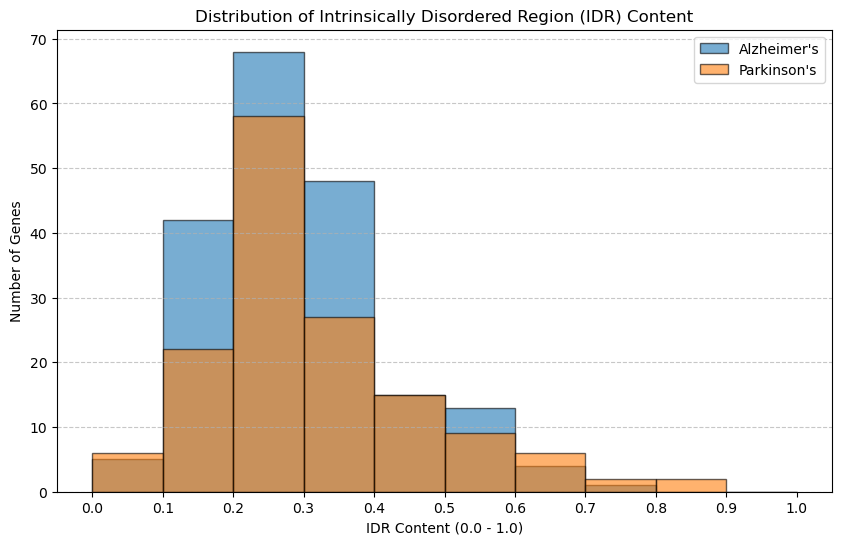

In [12]:
alzheimer_filtered = alzheimer_char.dropna(subset=['sequence'])
parkinson_filtered = parkinson_char.dropna(subset=['sequence'])

alzheimer_mean_idr = alzheimer_filtered['idr_content'].mean()
parkinson_mean_idr = parkinson_filtered['idr_content'].mean()

print(f"Mean IDR content for Alzheimer's: {alzheimer_mean_idr:.2f}")
print(f"Mean IDR content for Parkinson's: {parkinson_mean_idr:.2f}")


bins = np.arange(0, 1.1, 0.1)

plt.figure(figsize=(10, 6))

plt.hist(
    alzheimer_filtered['idr_content'],
    bins=bins,
    label="Alzheimer's",
    alpha=0.6,
    edgecolor='black'
)
plt.hist(
    parkinson_filtered['idr_content'],
    bins=bins,
    label="Parkinson's",
    alpha=0.6,
    edgecolor='black'
)

plt.title('Distribution of Intrinsically Disordered Region (IDR) Content')
plt.xlabel('IDR Content (0.0 - 1.0)')
plt.ylabel('Number of Genes')
plt.xticks(bins)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('idr_content_distribution.pdf')
plt.show()

In [42]:
alzheimer_filtered.head(5)

,gene_symbol,score,gene_ensembl,disease_name,geneDescription,gene_type,genep_str_ids,dsi,sequence,seq_length,disease,idr_content,idr_length,region_interval
0,APP,1.0,ENSG00000142192,Alzheimer's Disease,amyloid beta precursor protein,protein-coding,P05067,0.40,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,770.0,Alzheimer,0.293506,226,"1-2,25-25,49-57,158-164,191-210,217-221,230-25..."
1,PSEN1,1.0,ENSG00000080815,Alzheimer's Disease,presenilin 1,protein-coding,P49768,0.44,MTELPAPLSYFQNAQMSEDNHLSNTVRSQNDNRERQEHNDRRSLGH...,467.0,Alzheimer,0.265525,124,"1-5,8-8,13-19,25-64,103-115,120-122,301-331,34..."
2,APOE,1.0,ENSG00000130203,Alzheimer's Disease,apolipoprotein E,protein-coding,P02649,0.32,MKVLWAALLVTFLAGCQAKVEQAVETEPEPELRQQTEWQSGQRWEL...,317.0,Alzheimer,0.249211,79,"1-2,26-40,97-100,121-126,145-147,182-192,201-2..."
3,MAPT,1.0,ENSG00000186868,Alzheimer's Disease,microtubule associated protein tau,protein-coding,P10636,0.36,MAEPRQEFEVMEDHAGTYGLGDRKDQGGYTMHQDQEGDTDAGLKES...,758.0,Alzheimer,0.610818,463,"1-4,6-7,10-10,13-26,38-44,50-72,83-84,86-100,1..."
4,PSEN2,1.0,ENSG00000143801,Alzheimer's Disease,presenilin 2,protein-coding,P49810,0.47,MLTFMASDSEEEVCDERTSLMSAESPTPRSCQEGRQGPEDGENTAQ...,448.0,Alzheimer,0.191964,86,"1-11,18-45,51-64,69-73,113-117,120-130,285-285..."


In [44]:
parkinson_filtered.head(5)

,gene_symbol,score,gene_ensembl,disease_name,geneDescription,gene_type,genep_str_ids,dsi,sequence,seq_length,disease,idr_content,idr_length,region_interval
0,SNCA,1.0,ENSG00000145335,Parkinson Disease,synuclein alpha,protein-coding,P37840,0.40,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,140.0,Parkinson,0.664286,93,"1-6,9-11,13-16,24-48,57-68,92-119,125-132,134-140"
1,LRRK2,1.0,ENSG00000188906,Parkinson Disease,leucine rich repeat kinase 2,protein-coding,Q5S007,0.47,MASGSCQGCEEDEETLKKLIVRLNNVQEGKQIETLVQILEDLLVFT...,2527.0,Parkinson,0.180055,455,"1-11,25-31,53-60,196-203,331-344,473-474,762-7..."
2,GBA1,1.0,ENSG00000177628,Parkinson Disease,glucosylceramidase beta 1,protein-coding,P04062,0.44,MEFSSPSREECPKPLSRVSIMAGSLTGLLLLQAVSWASGARPCIPK...,536.0,Parkinson,0.143657,77,"1-15,65-75,215-223,229-241,505-530,532-532,535..."
3,PRKN,1.0,ENSG00000185345,Parkinson Disease,parkin RBR E3 ubiquitin protein ligase,protein-coding,O60260,0.42,MIVFVRFNSSHGFPVEVDSDTSIFQLKEVVAKRQGVPADQLRVIFA...,465.0,Parkinson,0.335484,156,"1-2,7-23,31-39,49-52,55-66,71-91,102-113,125-1..."
4,VPS35,1.0,ENSG00000069329,Parkinson Disease,VPS35 retromer complex component,protein-coding,Q96QK1,0.59,MPTTQQSPQDEQEKLLDEAIQAVKVQSFQMKRCLDKNKLMDALKHA...,796.0,Parkinson,0.204774,163,"1-11,27-33,54-57,145-145,160-168,171-177,198-2..."


In [14]:
alzheimer_filtered = alzheimer_char.dropna(subset=['sequence'])
parkinson_filtered = parkinson_char.dropna(subset=['sequence'])

In [94]:
idr_alzheimer = alzheimer_filtered["idr_content"]
idr_parkinson = parkinson_filtered["idr_content"]

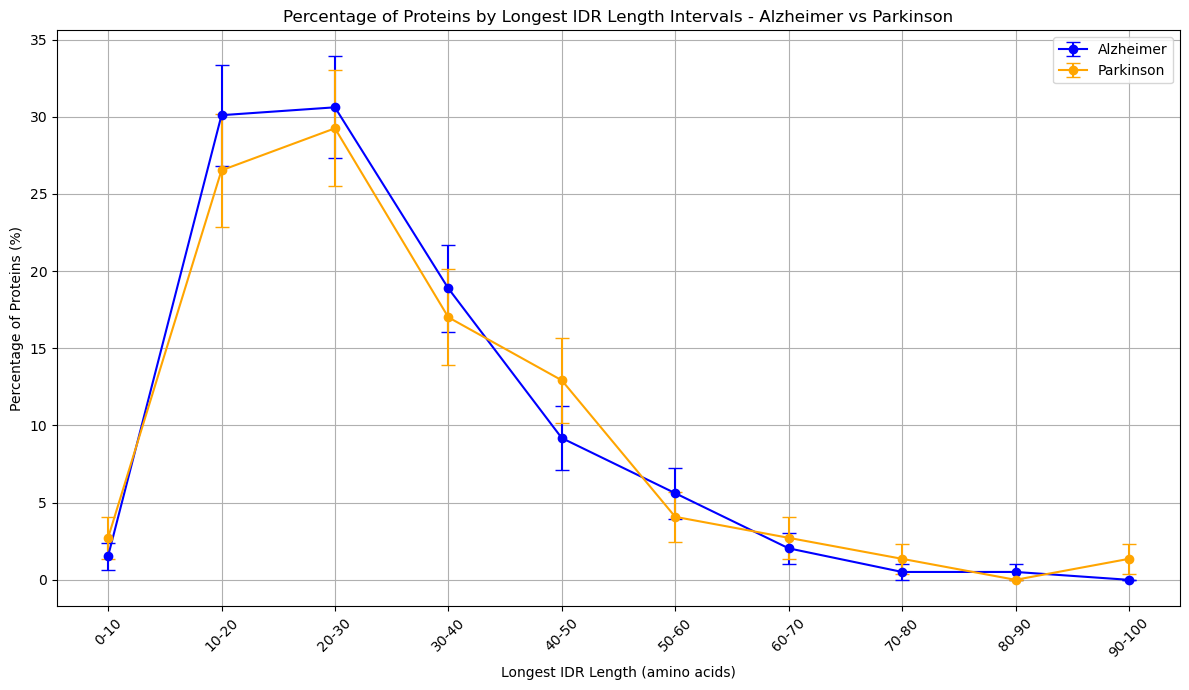

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Function to compute the longest IDR region length from the region_interval string
def get_longest_idr(region_str):
    if pd.isna(region_str) or not region_str:
        return 0
    regions = region_str.split(',')
    max_len = 0
    for reg in regions:
        reg = reg.strip()
        if '-' in reg:
            try:
                start, end = map(int, reg.split('-'))
                length = end - start + 1
                if length > max_len:
                    max_len = length
            except ValueError:
                continue  # Skip invalid intervals
    return max_len

# Add the 'longest_idr' column to both DataFrames
alzheimer_filtered['longest_idr'] = alzheimer_filtered['region_interval'].apply(get_longest_idr)
parkinson_filtered['longest_idr'] = parkinson_filtered['region_interval'].apply(get_longest_idr)

# Define bins: 0-10, 10-20, ..., 90-100
bin_edges = np.arange(0, 101, 10)
bin_centers = bin_edges[:-1] + 5  # Centers: 5, 15, ..., 95

# Function to compute percentages and errors
def compute_percentages_errors(df):
    if df.empty:
        return np.zeros(len(bin_centers)), np.zeros(len(bin_centers))
    
    counts, _ = np.histogram(df['longest_idr'], bins=bin_edges)
    total_proteins = len(df)
    percentages = (counts / total_proteins) * 100 if total_proteins > 0 else np.zeros_like(counts)
    errors = np.sqrt((percentages / 100) * (1 - percentages / 100) / total_proteins) * 100
    errors = np.nan_to_num(errors)  # Handle NaN if any
    return percentages, errors

# Compute for both
alz_percentages, alz_errors = compute_percentages_errors(alzheimer_filtered)
park_percentages, park_errors = compute_percentages_errors(parkinson_filtered)

# Plot both on the same figure
plt.figure(figsize=(12, 7))
plt.errorbar(bin_centers, alz_percentages, yerr=alz_errors, fmt='o-', capsize=5, color='blue', label='Alzheimer')
plt.errorbar(bin_centers, park_percentages, yerr=park_errors, fmt='o-', capsize=5, color='orange', label='Parkinson')
plt.xlabel('Longest IDR Length (amino acids)')
plt.ylabel('Percentage of Proteins (%)')
plt.title('Percentage of Proteins by Longest IDR Length Intervals - Alzheimer vs Parkinson')
plt.xticks(bin_centers, labels=[f'{int(bin_edges[i])}-{int(bin_edges[i+1])}' for i in range(len(bin_centers))], rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('longest_idr.pdf')
plt.show()

In [132]:
long_alz = alzheimer_filtered["longest_idr"]
long_park = parkinson_filtered["longest_idr"]

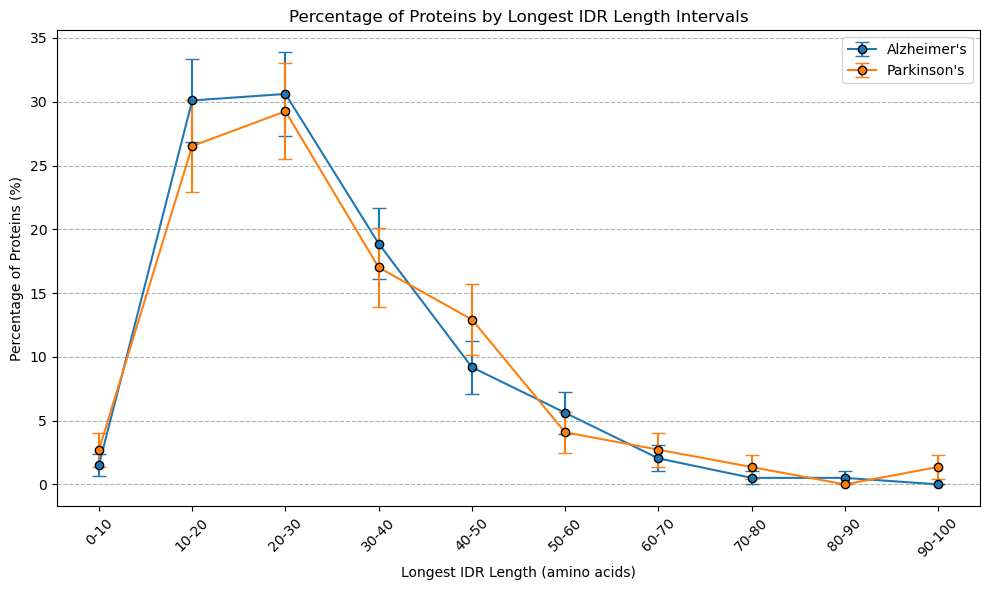

In [24]:
plt.figure(figsize=(10, 6))

plt.errorbar(
    bin_centers,
    alz_percentages,
    yerr=alz_errors,
    fmt='o-',
    capsize=5,
    alpha=1,
    color='#1f77b4',  # Updated to a standard matplotlib blue hex code
    label='Alzheimer\'s',
    markeredgecolor='black'  # Added to match histogram style
)
plt.errorbar(
    bin_centers,
    park_percentages,
    yerr=park_errors,
    fmt='o-',
    capsize=5,
    alpha=1,
    color='#ff7f0e',  # Updated to a standard matplotlib orange hex code
    label='Parkinson\'s',
    markeredgecolor='black'  # Added to match histogram style
)

# Add plot labels and title
plt.title('Percentage of Proteins by Longest IDR Length Intervals')
plt.xlabel('Longest IDR Length (amino acids)')
plt.ylabel('Percentage of Proteins (%)')
plt.xticks(bin_centers, labels=[f'{int(bin_edges[i])}-{int(bin_edges[i+1])}' for i in range(len(bin_centers))], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=1)
plt.tight_layout()
plt.savefig('longest_idr.pdf')
plt.show()

## Phase 5: Variant-Disease Association

### Phase 5.1: All variants for GDA both diseases

In [72]:
def fetch_uniprot_variants(uniprot_id, gene_symbol):
    """Fetch natural variants for a given UniProt accession."""
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
    r = requests.get(url)
    if r.status_code != 200:
        return []
    
    data = r.json()
    variants = []
    for feat in data.get("features", []):
        if feat.get("type") == "Natural variant":
            location = feat.get("location", {})
            start = location.get("start", {}).get("value")
            end = location.get("end", {}).get("value")
            if start and end and start == end:
                pos = start
                variant_id = feat.get("featureId", "")
                alt_seq = feat.get("alternativeSequence", {})
                ref_aa = alt_seq.get("originalSequence", "")
                alt_aa_list = alt_seq.get("alternativeSequences", [])
                alt_aa = alt_aa_list[0] if alt_aa_list else ""
                if len(ref_aa) == 1 and len(alt_aa) == 1:
                    # Extract dbSNP from cross-references
                    dbsnp = ""
                    for xref in feat.get("featureCrossReferences", []):
                        if xref.get("database") == "dbSNP":
                            dbsnp = xref.get("id")
                            break
                    
                    variants.append({
                        "variant_id": variant_id,
                        "uniprot_acc": uniprot_id,
                        "gene_symbol": gene_symbol,
                        "dbSNP": dbsnp,
                        "pos": pos,
                        "ref_aa": ref_aa,
                        "alt_aa": alt_aa
                    })
    return variants

def build_all_variants_table(df, outfile):
    all_vars = []
    for _, row in df.iterrows():
        uid = row["genep_str_ids"]
        gene_symbol = row["gene_symbol"]
        if pd.notna(uid):
            vars_ = fetch_uniprot_variants(uid, gene_symbol)
            all_vars.extend(vars_)
    pd.DataFrame(all_vars).to_csv(outfile, sep="\t", index=False)

In [74]:
build_all_variants_table(alzheimer, "all_variants_alzheimer_genes.tsv")
build_all_variants_table(parkinson, "all_variants_parkinson_genes.tsv")

print("All variants saved for genes (UniProt).")

All variants saved for genes (UniProt).


In [55]:
alzheimer_variants.head(5)

,variant_id,uniprot_acc,gene_symbol,dbSNP,pos,ref_aa,alt_aa,change,in_slim,in_idr
0,VAR_022315,P05067,APP,rs45588932,501,E,K,E -> K,False,False
1,VAR_010107,P05067,APP,rs63750363,665,E,D,E -> D,False,True
2,VAR_044424,P05067,APP,rs63750064,678,D,N,D -> N,False,False
3,VAR_000016,P05067,APP,rs63750671,692,A,G,A -> G,False,False
4,VAR_014215,P05067,APP,rs63751039,693,E,G,E -> G,False,False


In [7]:
alzheimer_variants.shape

(2226, 7)

In [48]:
parkinson_variants.head(5)

,genep_str_ids,gene_symbol,disease,sequence,seq_length,idr_content,idr_length,region_interval
0,P37840,SNCA,Parkinson,MDVFMKGLSKAKEGVVAAAEKTKQGVAEAAGKTKEGVLYVGSKTKE...,140.0,0.664286,93,"1-6,9-11,13-16,24-48,57-68,92-119,125-132,134-140"
1,Q5S007,LRRK2,Parkinson,MASGSCQGCEEDEETLKKLIVRLNNVQEGKQIETLVQILEDLLVFT...,2527.0,0.180055,455,"1-11,25-31,53-60,196-203,331-344,473-474,762-7..."
2,P04062,GBA1,Parkinson,MEFSSPSREECPKPLSRVSIMAGSLTGLLLLQAVSWASGARPCIPK...,536.0,0.143657,77,"1-15,65-75,215-223,229-241,505-530,532-532,535..."
3,O60260,PRKN,Parkinson,MIVFVRFNSSHGFPVEVDSDTSIFQLKEVVAKRQGVPADQLRVIFA...,465.0,0.335484,156,"1-2,7-23,31-39,49-52,55-66,71-91,102-113,125-1..."
4,Q96QK1,VPS35,Parkinson,MPTTQQSPQDEQEKLLDEAIQAVKVQSFQMKRCLDKNKLMDALKHA...,796.0,0.204774,163,"1-11,27-33,54-57,145-145,160-168,171-177,198-2..."


In [11]:
parkinson_variants.shape

(2084, 7)

In [140]:
def compute_variant_overlap(variants_df, idr_df):
    def parse_intervals(interval_str):
        intervals = []
        for part in interval_str.split(","):
            start, end = map(int, part.split("-"))
            intervals.append((start, end))
        return intervals

    results = []

    for _, idr_row in idr_df.iterrows():
        uniprot = idr_row["genep_str_ids"]
        gene = idr_row["gene_symbol"]
        seq_length = idr_row["seq_length"]
        idr_content = idr_row["idr_content"]

        var_subset = variants_df[variants_df["uniprot_acc"] == uniprot]
        n_variants = len(var_subset)

        if n_variants == 0:
            results.append([uniprot, gene, seq_length, idr_content, 0, 0, 0.0])
            continue
        
        intervals = parse_intervals(idr_row["region_interval"])
        
        n_dis_variants = 0
        for _, var in var_subset.iterrows():
            pos = int(var["pos"])
            if any(start <= pos <= end for start, end in intervals):
                n_dis_variants += 1

        percentage = n_dis_variants / n_variants if n_variants > 0 else 0
        results.append([uniprot, gene, seq_length, idr_content, n_variants, n_dis_variants, percentage])

    out_df = pd.DataFrame(results, columns=[
        "genep_str_ids", "gene_symbol", "seq_length", "idr_content", 
        "n_variants", "n_dis_variants", "percentage"
    ])
    return out_df

In [142]:
alzheimer_summary = compute_variant_overlap(alzheimer_variants, alzheimer_char)
parkinson_summary = compute_variant_overlap(parkinson_variants, parkinson_char)

In [23]:
print(alzheimer_summary.shape)
alzheimer_summary.head(10)

(209, 7)


,genep_str_ids,gene_symbol,seq_length,idr_content,n_variants,n_dis_variants,percentage
0,P05067,APP,770.0,0.293506,20,1,0.050000
1,P49768,PSEN1,467.0,0.265525,129,11,0.085271
2,P02649,APOE,317.0,0.249211,30,7,0.233333
3,P10636,MAPT,758.0,0.610818,28,20,0.714286
4,P49810,PSEN2,448.0,0.191964,11,6,0.545455
5,P28799,GRN,593.0,0.156830,13,3,0.230769
6,P12821,ACE,1306.0,0.107963,24,2,0.083333
7,O96008,TOMM40,361.0,0.113573,0,0,0.000000
8,P10909,CLU,449.0,0.311804,3,2,0.666667
9,Q92692,NECTIN2,538.0,0.323420,0,0,0.000000


In [25]:
print(parkinson_summary.shape)
parkinson_summary.head(10)

(153, 7)


,genep_str_ids,gene_symbol,seq_length,idr_content,n_variants,n_dis_variants,percentage
0,P37840,SNCA,140.0,0.664286,4,2,0.500000
1,Q5S007,LRRK2,2527.0,0.180055,58,17,0.293103
2,P04062,GBA1,536.0,0.143657,178,22,0.123596
3,O60260,PRKN,465.0,0.335484,40,10,0.250000
4,Q96QK1,VPS35,796.0,0.204774,11,2,0.181818
5,Q9BXM7,PINK1,581.0,0.197935,69,9,0.130435
6,Q99497,PARK7,189.0,0.380952,11,4,0.363636
7,P39905,GDNF,211.0,0.616114,5,3,0.600000
8,P10636,MAPT,758.0,0.610818,28,20,0.714286
9,P23560,BDNF,247.0,0.558704,6,2,0.333333


In [144]:
alzheimer_pct = np.round(np.mean(alzheimer_summary["percentage"]), 4)
parkinson_pct = np.round(np.mean(parkinson_summary["percentage"]),4)

print(f"Pctg variants in IDR in Alzheimer: {alzheimer_pct}")
print(f"Pctg variants in IDR in Parkinson: {parkinson_pct}")

Pctg variants in IDR in Alzheimer: 0.2812
Pctg variants in IDR in Parkinson: 0.2962


Frequency of all amino acid changes for Alzheimer's:
     Change  Frequency
0    R -> Q         82
1    R -> C         74
2    E -> K         72
3    A -> T         64
4    R -> H         58
..      ...        ...
163  W -> K          1
164  W -> E          1
165  L -> E          1
166  K -> I          1
167  Y -> D          1

[168 rows x 2 columns]

Frequency of all amino acid changes for Parkinson's:
     Change  Frequency
0    R -> Q         77
1    A -> T         64
2    R -> C         64
3    P -> L         59
4    R -> H         53
..      ...        ...
161  W -> E          1
162  E -> N          1
163  G -> W          1
164  M -> K          1
165  Y -> F          1

[166 rows x 2 columns]


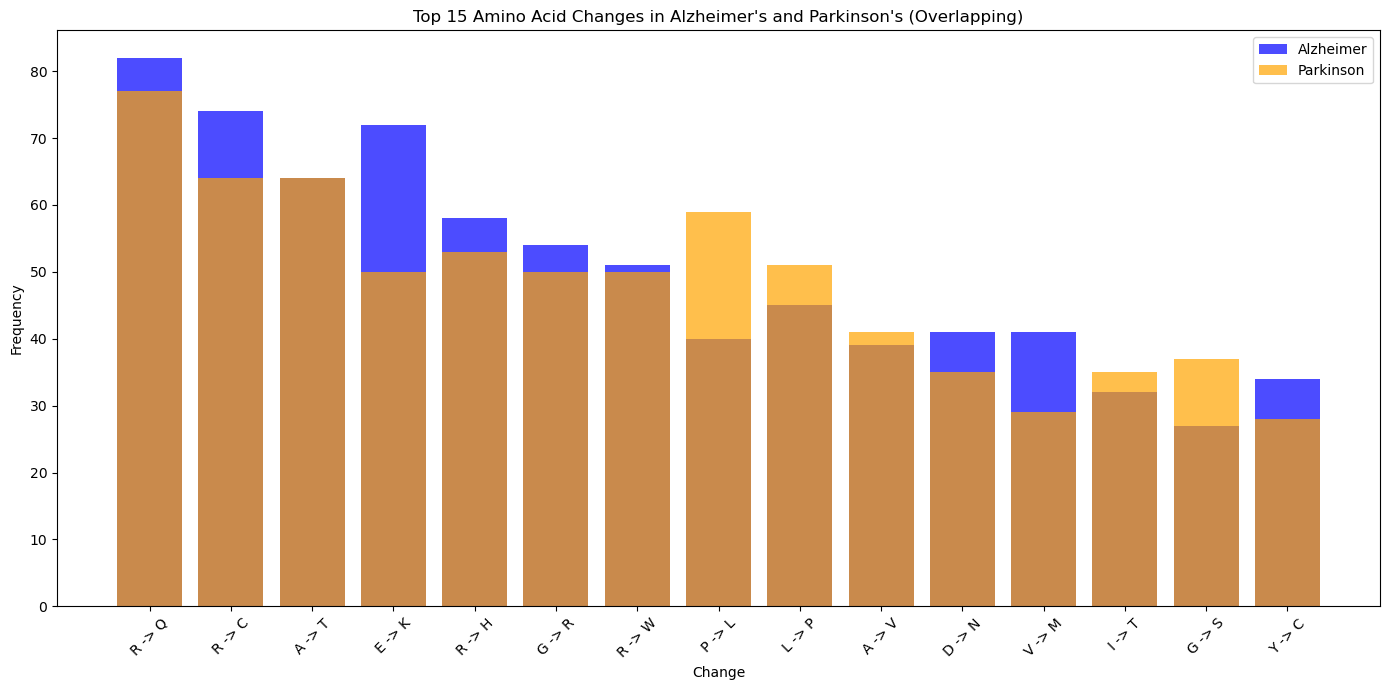

In [58]:
alzheimer_variants['change'] = alzheimer_variants['ref_aa'] + ' -> ' + alzheimer_variants['alt_aa']
parkinson_variants['change'] = parkinson_variants['ref_aa'] + ' -> ' + parkinson_variants['alt_aa']

alz_counts = alzheimer_variants['change'].value_counts()
park_counts = parkinson_variants['change'].value_counts()

# Display full frequency tables
print("Frequency of all amino acid changes for Alzheimer's:")
print(pd.DataFrame({'Change': alz_counts.index, 'Frequency': alz_counts.values}))
print("\nFrequency of all amino acid changes for Parkinson's:")
print(pd.DataFrame({'Change': park_counts.index, 'Frequency': park_counts.values}))

all_changes = set(alz_counts.index).union(set(park_counts.index))

# Create combined data
data = []
alz_dict = dict(alz_counts)
park_dict = dict(park_counts)
for change in all_changes:
    alz_f = alz_dict.get(change, 0)
    park_f = park_dict.get(change, 0)
    data.append((change, alz_f, park_f, alz_f + park_f))

# Create dataframe and sort by total frequency
combined_df = pd.DataFrame(data, columns=['change', 'alz_freq', 'park_freq', 'total'])
combined_df.sort_values('total', ascending=False, inplace=True)

# Get top 15
top_df = combined_df.head(15)

fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(top_df['change'], top_df['alz_freq'], color='blue', alpha=0.7, label='Alzheimer')
ax.bar(top_df['change'], top_df['park_freq'], color='orange', alpha=0.7, label='Parkinson')
ax.set_title("Top 15 Amino Acid Changes in Alzheimer's and Parkinson's (Overlapping)")
ax.set_xlabel('Change')
ax.set_ylabel('Frequency')
ax.tick_params(axis='x', rotation=45)
ax.legend()
plt.tight_layout()
plt.savefig('top_aminoacids_changue.pdf')
plt.show()

In [41]:
alz_elms = pd.read_csv('Alzheimer_elms_top_2.tsv', sep='\t')
park_elms = pd.read_csv('Parkinson_elms_top_2.tsv', sep='\t')

def is_in_slim(row, elms_df):
    uniprot = row['uniprot_acc']
    pos = row['pos']
    protein_elms = elms_df[elms_df['genep_str_ids'] == uniprot]
    for _, elm_row in protein_elms.iterrows():
        region_str = elm_row['region']
        try:
            region = ast.literal_eval(region_str)
            start, end = int(region[0]), int(region[1])
            if start <= pos <= end:
                return True
        except:
            continue 
    return False


alzheimer_variants['in_slim'] = alzheimer_variants.apply(lambda row: is_in_slim(row, alz_elms), axis=1)
alz_percentage = (alzheimer_variants['in_slim'].sum() / len(alzheimer_variants)) * 100 if len(alzheimer_variants) > 0 else 0
print(f"Percentage of variants in SLiMs for Alzheimer's: {alz_percentage:.2f}%")


parkinson_variants['in_slim'] = parkinson_variants.apply(lambda row: is_in_slim(row, park_elms), axis=1)
park_percentage = (parkinson_variants['in_slim'].sum() / len(parkinson_variants)) * 100 if len(parkinson_variants) > 0 else 0
print(f"Percentage of variants in SLiMs for Parkinson's: {park_percentage:.2f}%")

print("\nUpdated Alzheimer's variants:")
print(alzheimer_variants.head())
print("\nUpdated Parkinson's variants:")
print(parkinson_variants.head())

Percentage of variants in SLiMs for Alzheimer's: 7.46%
Percentage of variants in SLiMs for Parkinson's: 13.63%

Updated Alzheimer's variants:
   variant_id uniprot_acc gene_symbol       dbSNP  pos ref_aa alt_aa  change  \
0  VAR_022315      P05067         APP  rs45588932  501      E      K  E -> K   
1  VAR_010107      P05067         APP  rs63750363  665      E      D  E -> D   
2  VAR_044424      P05067         APP  rs63750064  678      D      N  D -> N   
3  VAR_000016      P05067         APP  rs63750671  692      A      G  A -> G   
4  VAR_014215      P05067         APP  rs63751039  693      E      G  E -> G   

   in_slim  
0    False  
1    False  
2    False  
3    False  
4    False  

Updated Parkinson's variants:
   variant_id uniprot_acc gene_symbol        dbSNP  pos ref_aa alt_aa  change  \
0  VAR_007957      P37840        SNCA  rs104893878   30      A      P  A -> P   
1  VAR_022703      P37840        SNCA  rs104893875   46      E      K  E -> K   
2  VAR_070171      P37840

## Phase 5: Motifs in IDRs

**Useful information**: we are using the ELM API which contains for each UniProt entry the ELMs motifs that are present, we are filtering according to the column is filtered, anotating not the subtype of ELMs we are looking for keywords. 

`is_filtered`: Whether or not this motif was rejected by any of the ELM prediction filters (structure, topodom or taxon).

In [54]:
# List of target motif keywords
motifs = ['14-3-3', 'SH2', 'SH3', 'CDK', 'DEG', 'PDZ', 'PKA']

def process_disease(disease):
    input_file = f"{disease}_Full_Genes.tsv"
    output_file = f"{disease}_elms_top_2.tsv"  
    
    df = pd.read_csv(input_file, sep='\t')
    
    df = df.sort_values(by='score', ascending=False)
    
    output_list = []
    
    for index, row in df.iterrows():
        uniprot = row['genep_str_ids']
        gene = row['gene_symbol']
        
        url = f"http://elm.eu.org/start_search/{uniprot}.tsv"
        try:
            response = requests.get(url)
            if response.status_code == 200:
                tsv_content = response.text
                tsv_df = pd.read_csv(io.StringIO(tsv_content), sep='\t')
                
                mask = tsv_df['elm_identifier'].str.contains('|'.join(motifs), case=False, na=False)
                filtered = tsv_df[mask]
                
                if 'is_filtered' in filtered.columns:
                    filtered = filtered[filtered['is_filtered'].astype(str).str.lower() != 'true']
                
                for i, r in filtered.iterrows():
                    type_elm = next((m for m in motifs if m.lower() in str(r['elm_identifier']).lower()), '')
                    if type_elm:
                        region = f"[{int(r['start'])}, {int(r['stop'])}]"
                        output_list.append({
                            'gene_symbol': gene,
                            'genep_str_ids': uniprot,
                            'type_ELM': type_elm,
                            'region': region
                        })
            elif response.status_code == 429:
                print(f"Rate limit hit for {uniprot}. Waiting longer...")
                time.sleep(15) 
            else:
                print(f"Error fetching {uniprot}: Status {response.status_code}")
        except Exception as e:
            print(f"Exception for {uniprot}: {e}")
        
        # Respect rate limit: wait 3 minutes (180 seconds)
        time.sleep(20)

    if output_list:
        output_df = pd.DataFrame(output_list)
        output_df.to_csv(output_file, sep='\t', index=False)
        print(f"Output saved to {output_file}")
    else:
        print(f"No matching ELMs found for {disease}")

In [56]:
process_disease("Parkinson")

Rate limit hit for O60260. Waiting longer...
Rate limit hit for Q99497. Waiting longer...
Rate limit hit for P07101. Waiting longer...
Rate limit hit for P27338. Waiting longer...
Rate limit hit for Q5S007. Waiting longer...
Rate limit hit for Q9UBK2. Waiting longer...
Rate limit hit for Q9NQ11. Waiting longer...
Rate limit hit for P00441. Waiting longer...
Rate limit hit for P14416. Waiting longer...
Rate limit hit for P01584. Waiting longer...
Rate limit hit for O43426. Waiting longer...
Rate limit hit for P05231. Waiting longer...
Rate limit hit for P08183. Waiting longer...
Rate limit hit for P29475. Waiting longer...
Rate limit hit for Q9Y3I1. Waiting longer...
Rate limit hit for P09488. Waiting longer...
Rate limit hit for P38646. Waiting longer...
Rate limit hit for P21397. Waiting longer...
Rate limit hit for P15559. Waiting longer...
Rate limit hit for P01138. Waiting longer...
Rate limit hit for P54098. Waiting longer...
Rate limit hit for P31749. Waiting longer...
Rate limit

In [57]:
process_disease("Alzheimer")

Rate limit hit for P20138. Waiting longer...
Rate limit hit for P49768. Waiting longer...
Rate limit hit for P37840. Waiting longer...
Rate limit hit for P56817. Waiting longer...
Rate limit hit for P01375. Waiting longer...
Rate limit hit for P06276. Waiting longer...
Rate limit hit for P01584. Waiting longer...
Rate limit hit for P02654. Waiting longer...
Error fetching Q9Y5Z0: Status 500
Rate limit hit for O96008. Waiting longer...
Rate limit hit for P49810. Waiting longer...
Rate limit hit for P12821. Waiting longer...
Rate limit hit for P28799. Waiting longer...
Rate limit hit for Q92692. Waiting longer...
Rate limit hit for Q8IZY2. Waiting longer...
Rate limit hit for O00499. Waiting longer...
Rate limit hit for P08473. Waiting longer...
Rate limit hit for P01911. Waiting longer...
Rate limit hit for Q00059. Waiting longer...
Rate limit hit for Q9Y6A2. Waiting longer...
Error fetching P27338: Status 503
Rate limit hit for Q30201. Waiting longer...
Rate limit hit for P29474. Waiti

## Phase 6: Human Proteome

UniProt provides a downloadable reviewed (Swiss-Prot) human proteome FASTA/TSV.

Contains ~20k proteins with UniProt accessions + gene symbols + sequence length.

We are going to filter by Swiss-Prot, 5 points accuracy and a sequence length according to the one of GDA for Obesity and Hypertension

In [48]:
def sample_human_proteome(n, input_file='human_proteome.tsv', output_file='human_proteome_sampled.tsv'):
    df = pd.read_csv(input_file, sep='\t')
    
    df_renamed = pd.DataFrame({
        'gene_symbol': df['Gene Names'],
        'genep_str_ids': df['Entry'],
        'geneDescription': df['Protein names'],
        'sequence': df['Sequence'],
        'seq_length': df['Length']
    })
    
    if n > len(df_renamed):
        raise ValueError(f"N cannot be larger than the number of proteins in the file ({len(df_renamed)})")
    df_sampled = df_renamed.sample(n=n, random_state=42)  
    df_sampled.to_csv(output_file, sep='\t', index=False)
    
    return pd.read_csv(output_file, sep='\t')

In [50]:
human_proteome = sample_human_proteome(100)

In [52]:
human_proteome.head(10)

,gene_symbol,genep_str_ids,geneDescription,sequence,seq_length
0,NRBP1 BCON3 NRBP,Q9UHY1,Nuclear receptor-binding protein,MSEGESQTVLSSGSDPKVESSSSAPGLTSVSPPVTSTTSAASPEEE...,535
1,CABYR CBP86 FSP2,O75952,Calcium-binding tyrosine phosphorylation-regul...,MISSKPRLVVPYGLKTLLEGISRAVLKTNPSNINQFAAAYFQELTM...,493
2,CELF5 BRUNOL5,Q8N6W0,CUGBP Elav-like family member 5 (CELF-5) (Brun...,MARLTESEARRQQQQLLQPRPSPVGSSGPEPPGGQPDGMKDLDAIK...,485
3,SLC45A2 AIM1 MATP,Q9UMX9,Membrane-associated transporter protein (Melan...,MGSNSGQAGRHIYKSLADDGPFDSVEPPKRPTSRLIMHSMAMFGRE...,530
4,FGB,P02675,Fibrinogen beta chain [Cleaved into: Fibrinope...,MKRMVSWSFHKLKTMKHLLLLLLCVFLVKSQGVNDNEEGFFSARGH...,491
5,SRSF4 SFRS4 SRP75,Q08170,Serine/arginine-rich splicing factor 4 (Pre-mR...,MPRVYIGRLSYQARERDVERFFKGYGKILEVDLKNGYGFVEFDDLR...,494
6,BACE1 BACE KIAA1149,P56817,Beta-secretase 1 (EC 3.4.23.46) (Aspartyl prot...,MAQALPWLLLWMGAGVLPAHGTQHGIRLPLRSGLGGAPLGLRLPRE...,501
7,PRKAA1 AMPK1,Q13131,5'-AMP-activated protein kinase catalytic subu...,MRRLSSWRKMATAEKQKHDGRVKIGHYILGDTLGVGTFGKVKVGKH...,559
8,PSAP GLBA SAP1,P07602,Prosaposin (Proactivator polypeptide) [Cleaved...,MYALFLLASLLGAALAGPVLGLKECTRGSAVWCQNVKTASDCGAVK...,524
9,FUCA2 PSEC0151 UNQ227/PRO260,Q9BTY2,Plasma alpha-L-fucosidase (EC 3.2.1.51) (Alpha...,MRPQELPRLAFPLLLLLLLLLPPPPCPAHSATRFDPTWESLDARQL...,467


In [54]:
np.mean(human_proteome["seq_length"])

502.72

In [64]:
human_char = characterize_idrs(human_proteome, 'Human')

# Select columns
columns = ['genep_str_ids', 'gene_symbol', 'disease', 'sequence', 'seq_length', 'idr_content', 'idr_length', 'region_interval']

# Save
human_char[columns].to_csv("human_idr_characterized.tsv", sep="\t", index=False)

print("Phase 4 complete. Characterized files saved.")

Phase 4 complete. Characterized files saved.


In [72]:
human_idr = pd.read_csv("human_idr_characterized.tsv", sep="\t")

In [58]:
human_idr.head(10)

,genep_str_ids,gene_symbol,disease,sequence,seq_length,idr_content,idr_length,region_interval
0,Q9UHY1,NRBP1 BCON3 NRBP,Human,MSEGESQTVLSSGSDPKVESSSSAPGLTSVSPPVTSTTSAASPEEE...,535,0.304673,163,"1-6,8-36,39-80,102-110,152-160,172-174,242-249..."
1,O75952,CABYR CBP86 FSP2,Human,MISSKPRLVVPYGLKTLLEGISRAVLKTNPSNINQFAAAYFQELTM...,493,0.458418,226,"1-12,25-31,67-130,136-156,211-214,243-256,259-..."
2,Q8N6W0,CELF5 BRUNOL5,Human,MARLTESEARRQQQQLLQPRPSPVGSSGPEPPGGQPDGMKDLDAIK...,485,0.191753,93,"1-7,14-27,52-60,76-83,108-133,141-147,196-203,..."
3,Q9UMX9,SLC45A2 AIM1 MATP,Human,MGSNSGQAGRHIYKSLADDGPFDSVEPPKRPTSRLIMHSMAMFGRE...,530,0.156604,83,"1-7,14-32,89-102,244-260,288-294,452-469,530-530"
4,P02675,FGB,Human,MKRMVSWSFHKLKTMKHLLLLLLCVFLVKSQGVNDNEEGFFSARGH...,491,0.338086,166,"1-6,8-8,33-36,38-73,87-93,136-144,176-180,182-..."
5,Q08170,SRSF4 SFRS4 SRP75,Human,MPRVYIGRLSYQARERDVERFFKGYGKILEVDLKNGYGFVEFDDLR...,494,0.846154,418,"1-17,56-100,111-117,131-142,158-494"
6,P56817,BACE1 BACE KIAA1149,Human,MAQALPWLLLWMGAGVLPAHGTQHGIRLPLRSGLGGAPLGLRLPRE...,501,0.227545,114,"1-1,3-3,29-36,42-65,119-126,136-139,146-152,16..."
7,Q13131,PRKAA1 AMPK1,Human,MRRLSSWRKMATAEKQKHDGRVKIGHYILGDTLGVGTFGKVKVGKH...,559,0.416816,233,"1-5,7-8,13-25,27-36,44-70,77-88,92-98,275-288,..."
8,P07602,PSAP GLBA SAP1,Human,MYALFLLASLLGAALAGPVLGLKECTRGSAVWCQNVKTASDCGAVK...,524,0.162214,85,"39-42,53-64,78-79,93-100,155-156,231-237,283-2..."
9,Q9BTY2,FUCA2 PSEC0151 UNQ227/PRO260,Human,MRPQELPRLAFPLLLLLLLLLPPPPCPAHSATRFDPTWESLDARQL...,467,0.107066,50,"1-7,156-158,259-266,286-289,337-340,370-389,45..."


In [60]:
np.mean(human_idr["idr_content"].head(50))

0.30119162379709025

## Phase 7: Aminoacid Sequences

In [68]:
AA_ORDER = list("ACDEFGHIKLMNPQRSTVWY")  

def parse_intervals(interval_str: str) -> List[Tuple[int, int]]:
    """
    Parse a region string like '1-12,108-114,319-332' into a list of (start, end) tuples, 1-based inclusive.
    Robust to spaces; returns [] for NaN/None/empty.
    """
    if interval_str is None or (isinstance(interval_str, float) and np.isnan(interval_str)):
        return []
    s = str(interval_str).strip()
    if not s:
        return []
    intervals = []
    for chunk in s.split(','):
        chunk = chunk.strip()
        if not chunk:
            continue
        m = re.match(r'^(\d+)\s*-\s*(\d+)$', chunk)
        if m:
            a, b = int(m.group(1)), int(m.group(2))
            if a <= b:
                intervals.append((a, b))
        else:
            m2 = re.match(r'^(\d+)$', chunk)
            if m2:
                pos = int(m2.group(1))
                intervals.append((pos, pos))
    return intervals

def extract_idr_residues(sequence: str, interval_str: str) -> str:
    """
    Given a full protein sequence and the 'region_interval' string, return the concatenated
    amino acids that fall in IDRs. Assumes 1-based inclusive intervals.
    """
    if not isinstance(sequence, str) or len(sequence) == 0:
        return ""
    seq = sequence
    residues = []
    for (start, end) in parse_intervals(interval_str):
        s0 = max(0, start - 1)
        e0 = min(len(seq), end)
        if s0 < e0:
            residues.append(seq[s0:e0])
    return "".join(residues)

def count_aa(sequence: str, aa_order: List[str] = AA_ORDER) -> Dict[str, int]:
    """
    Count occurrences of standard amino acids in a sequence string.
    Non-standard letters are ignored.
    """
    counts = {aa: 0 for aa in aa_order}
    for ch in sequence:
        if ch in counts:
            counts[ch] += 1
    return counts

def idr_amino_acid_frequencies(df: pd.DataFrame,
                               seq_col: str = "sequence",
                               interval_col: str = "region_interval",
                               aa_order: List[str] = AA_ORDER) -> pd.Series:
    """
    For a dataframe with columns [sequence, region_interval], compute overall AA frequencies
    within all IDR residues concatenated across the DF. Returns a Series of proportions (sums to 1).
    """
    total_counts = {aa: 0 for aa in aa_order}
    total_residues = 0

    for _, row in df.iterrows():
        seq = row.get(seq_col, "")
        intervals = row.get(interval_col, "")
        idr_seq = extract_idr_residues(seq, intervals)
        c = count_aa(idr_seq, aa_order)
        for aa in aa_order:
            total_counts[aa] += c[aa]
        total_residues += sum(c.values())

    if total_residues == 0:
        # Avoid division by zero; return zeros
        return pd.Series({aa: 0.0 for aa in aa_order})

    freqs = {aa: total_counts[aa] / total_residues for aa in aa_order}
    return pd.Series(freqs, name="frequency")

def make_grouped_barplot(freq_df: pd.DataFrame,
                         title: str = "Amino Acid Frequencies in IDRs",
                         ylabel: str = "Proportion",
                         figsize=(12, 6),
                         savepath: str = None):
    """
    freq_df: DataFrame indexed by amino acid (AA_ORDER), columns like ['Obesity','Hypertension','Human'].
             Values are proportions (0..1).
    Produces a single grouped bar chart. Does not set custom colors or styles.
    """
    plt.figure(figsize=figsize)
    ax = freq_df.loc[AA_ORDER].plot(kind='bar')  
    ax.set_xlabel("Amino Acid")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(title="")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig("Aminoacid_Frequencies.pdf", dpi=300, bbox_inches='tight')
    plt.show()

<Figure size 1200x600 with 0 Axes>

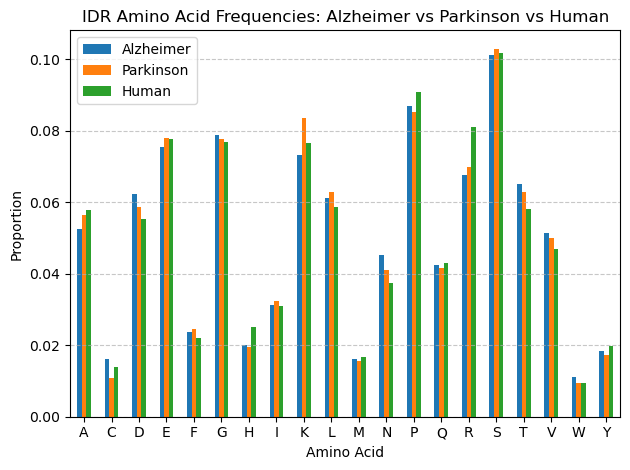

In [74]:
alzheimer_idr_freq  = idr_amino_acid_frequencies(alzheimer_char)
parkinson_idr_freq = idr_amino_acid_frequencies(parkinson_char)
human_idr_freq    = idr_amino_acid_frequencies(human_idr)

freq_df = pd.concat(
    [alzheimer_idr_freq.rename("Alzheimer"),
     parkinson_idr_freq.rename("Parkinson"),
     human_idr_freq.rename("Human")],
    axis=1
)
#
# Plot:
make_grouped_barplot(freq_df,
                     title="IDR Amino Acid Frequencies: Alzheimer vs Parkinson vs Human",
                     ylabel="Proportion",
                     figsize=(12,6),
                     savepath="idr_aa_frequencies.png")  

In [71]:
freq_df

,Alzheimer,Parkinson,Human
A,0.052589,0.056362,0.057930
C,0.016211,0.010743,0.014028
D,0.062197,0.058757,0.055332
E,0.075315,0.078065,0.077737
F,0.023737,0.024570,0.022146
G,0.078676,0.077702,0.076828
H,0.019989,0.019489,0.025068
I,0.031143,0.032445,0.030848
K,0.073262,0.083509,0.076503
L,0.061215,0.062822,0.058579


In [93]:
alz_elms.head(10)

,gene_symbol,genep_str_ids,type_ELM,region,inside_idr
0,APP,P05067,DEG,"[767, 770]",False
1,APP,P05067,SH2,"[728, 732]",False
2,APP,P05067,SH2,"[757, 760]",True
3,APP,P05067,SH2,"[755, 761]",True
4,APP,P05067,SH2,"[755, 761]",True
5,APP,P05067,SH2,"[728, 731]",True
6,APP,P05067,CDK,"[740, 747]",False
7,TTR,P02766,DEG,"[4, 12]",False
8,TTR,P02766,SH2,"[125, 129]",False
9,TTR,P02766,SH2,"[136, 140]",True


In [101]:
park_elms.head(10)

,gene_symbol,genep_str_ids,type_ELM,region
0,SNCA,P37840,DEG,"[1, 3]"
1,SNCA,P37840,SH2,"[123, 129]"
2,SNCA,P37840,SH2,"[123, 131]"
3,SNCA,P37840,SH2,"[39, 42]"
4,SNCA,P37840,SH3,"[114, 120]"
5,GBA1,P04062,DEG,"[533, 536]"
6,GBA1,P04062,DEG,"[1, 3]"
7,GBA1,P04062,14-3-3,"[170, 175]"
8,GBA1,P04062,14-3-3,"[209, 214]"
9,GBA1,P04062,SH2,"[155, 159]"


In [97]:
def parse_intervals(interval_str):
    if pd.isna(interval_str) or not interval_str:
        return []
    intervals = []
    for part in interval_str.split(','):
        part = part.strip()
        if part:
            try:
                start, end = map(int, part.split('-'))
                intervals.append((start, end))
            except ValueError:
                pass  
    return intervals

alz_elms = pd.read_csv('Alzheimer_elms_top_2.tsv', sep='\t')
park_elms = pd.read_csv('Parkinson_elms_top_2.tsv', sep='\t')

In [76]:
alz_elms = pd.read_csv('Alzheimer_elms_top_2.tsv', sep='\t')
park_elms = pd.read_csv('Parkinson_elms_top_2.tsv', sep='\t')

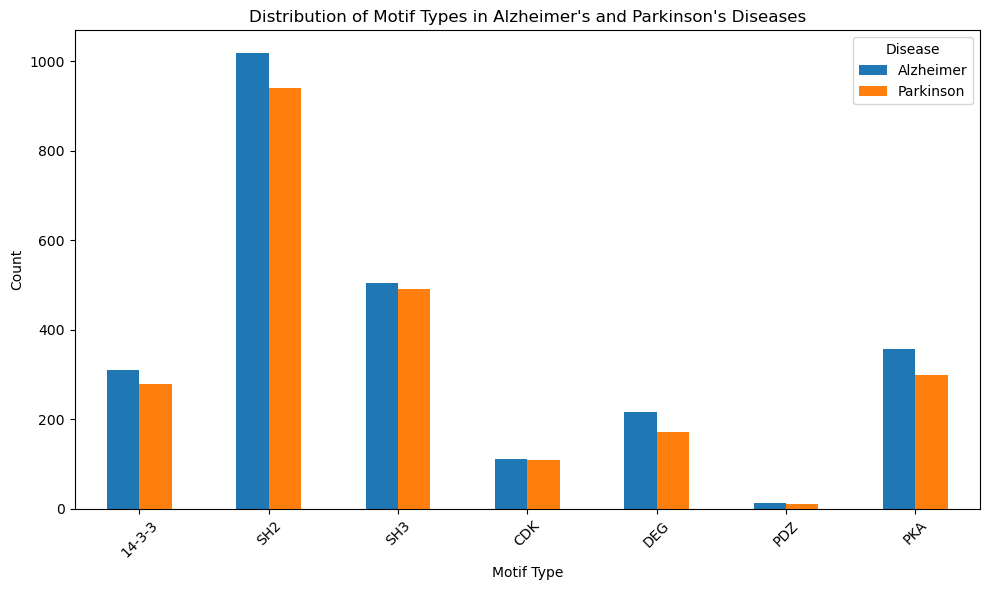

In [78]:
alz_counts = alz_elms['type_ELM'].value_counts()
park_counts = park_elms['type_ELM'].value_counts()

# List of considered motifs
motifs = ['14-3-3', 'SH2', 'SH3', 'CDK', 'DEG', 'PDZ', 'PKA']

counts_df = pd.DataFrame({
    'Alzheimer': alz_counts.reindex(motifs, fill_value=0),
    'Parkinson': park_counts.reindex(motifs, fill_value=0)
})


counts_df.plot(kind='bar', figsize=(10, 6))
plt.title("Distribution of Motif Types in Alzheimer's and Parkinson's Diseases")
plt.xlabel('Motif Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Disease')
plt.tight_layout()
plt.savefig("Motifs.pdf", dpi=300, bbox_inches='tight')
plt.show()  

In [86]:
def add_inside_idr(elms_df, filtered_df, output_file):
    # Create dict of protein to parsed IDR intervals
    idr_dict = {}
    for _, row in filtered_df.iterrows():
        prot = row['genep_str_ids']
        intervals = parse_intervals(row['region_interval'])
        idr_dict[prot] = intervals
    
    def is_inside(slim_region, intervals):
        if not intervals:
            return False
        start, end = literal_eval(slim_region)
        for i_start, i_end in intervals:
            if i_start <= start and end <= i_end:
                return True
        return False
    
    elms_df['inside_idr'] = elms_df['region'].apply(lambda r: is_inside(r, idr_dict.get(elms_df.loc[elms_df['region'] == r, 'genep_str_ids'].iloc[0], [])))
    
    elms_df.to_csv(output_file, sep='\t', index=False)
    
    summary = elms_df.groupby('genep_str_ids').agg(
        num_in_idr=('inside_idr', 'sum'),
        total_slims=('inside_idr', 'count')
    ).reset_index()
    summary.to_csv(output_file.replace('.tsv', '_summary.tsv'), sep='\t', index=False)

add_inside_idr(alz_elms, alzheimer_filtered, 'Alzheimer_elms_with_idr.tsv')

add_inside_idr(park_elms, parkinson_filtered, 'Parkinson_elms_with_idr.tsv')

In [103]:
alz_elms_with_idr = pd.read_csv('Alzheimer_elms_with_idr.tsv', sep='\t')
park_elms_with_idr = pd.read_csv('Parkinson_elms_with_idr.tsv', sep='\t')

# Compute percentage for Alzheimer's
alz_total = len(alz_elms_with_idr)
alz_inside = alz_elms_with_idr['inside_idr'].sum()
alz_percentage = (alz_inside / alz_total * 100) if alz_total > 0 else 0
print(f"Percentage of SLiMs inside IDR for Alzheimer's: {alz_percentage:.2f}%")

# Compute percentage for Parkinson's
park_total = len(park_elms_with_idr)
park_inside = park_elms_with_idr['inside_idr'].sum()
park_percentage = (park_inside / park_total * 100) if park_total > 0 else 0
print(f"Percentage of SLiMs inside IDR for Parkinson's: {park_percentage:.2f}%")

Percentage of SLiMs inside IDR for Alzheimer's: 23.18%
Percentage of SLiMs inside IDR for Parkinson's: 21.01%
